In [1]:
from sdm.utils import set_project_wd
set_project_wd()

Current Working Directory: /Users/matthewwhittle/Data Science/shefflied-bats


Load the DEM 

In [2]:
import richdem as rd
import numpy as np
import rioxarray as rxr
from sdm.geo import load_boundary

# Load the boundary
boundary = load_boundary()

# Load the DEM
dem = rd.LoadGDAL("data/evs/dtm-100m.tif")
dem_rxr = rxr.open_rasterio("data/evs/dtm-100m.tif")

In [3]:
terrain = dem_rxr.to_dataset(name = "dem")

This is the digital elevation model for the south yorkshire

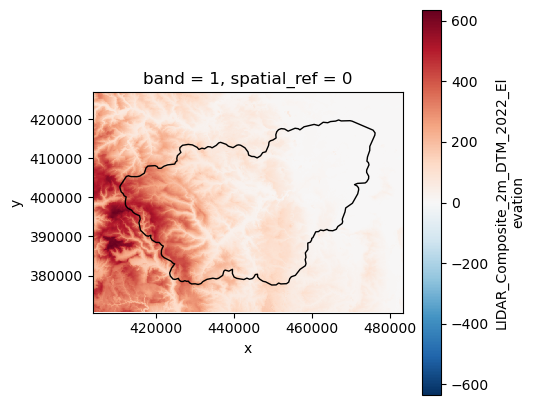

In [4]:
# Plot the DEM wqith the boundary
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (5, 5))
terrain.dem.plot(ax = ax)
boundary.plot(ax = ax, color = "none", edgecolor = "black")
plt.show()

# Calculate Terrain Statistics

From the Digital Elevation Model it is possible to calcualte a variety of statistics to describe the terrain. These aim to provide important features for the species distribution modelling for bats in south yorkshire.

Important Stats might include:
- Slope: The slope of the terrain
- Aspect (converted to Eastness, Northness): The direction the slope is facing
- Topographical Wetness Index: The potential wetness of the terrain
- Topographical Position Index: The relative position of the terrain (ridge, valley, etc)
- Roughness: How variable the terrain is.

In [5]:
# Calculate the slope in radians
slope = rd.TerrainAttribute(dem, attrib='slope_radians')
aspect = rd.TerrainAttribute(dem, attrib='aspect')

aspect_eastness = np.cos(aspect.data)
aspect_northness = np.sin(aspect.data)

# Avoid division by zero and very flat areas
# By adding a small value
# Convert memoryview to numpy array
slope_array = np.array(slope, copy=False)

# Avoid division by zero and very flat areas
# By adding a small value
slope_array[slope_array < 0.001] = 0.001



# Calculate flow accumulation or upslope contributing area
flowacc = rd.FlowAccumulation(dem, method='D8')

# Calculate the TWI
twi = np.log(flowacc.data/slope_array)



A Slope calculation (radians)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

W Cell X and Y dimensions are not equal!
t Wall-time = 0.00943975===================== ] (99% - 0.0s - 1 threads)

A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

W Cell X and Y dimensions are not equal!
t Wall-time = 0.0241582====================== ] (99% - 0.0s - 1 threads)

A O'Callaghan (1984)/Marks (1984) D8/D4 Flow Accumulation
C O'Callaghan, J.F., Mark, D.M., 1984. The Extraction of Drainage Networks from Digital Elevation Data. Computer vision, graphics, and image processing 28, 323--344.

c topology = D8
[================================================= ] (99% - 0.0s - 1 threads)
A Generic Flow Accumulation Algorithm
p Creating dependencies array...

d Source cells found = 175120
p Calculating flow accumulation...
t Wa

# Curvature, Roughness, and Topographic Position Index

In [6]:
# Curvature
curvature = rd.TerrainAttribute(dem, attrib='curvature')



A Curvature attribute calculation
C Zevenbergen, L.W., Thorne, C.R., 1987. Quantitative analysis of land surface topography. Earth surface processes and landforms 12, 47–56.

W Cell X and Y dimensions are not equal!
t Wall-time = 0.00440721===================== ] (99% - 0.0s - 1 threads) threads)


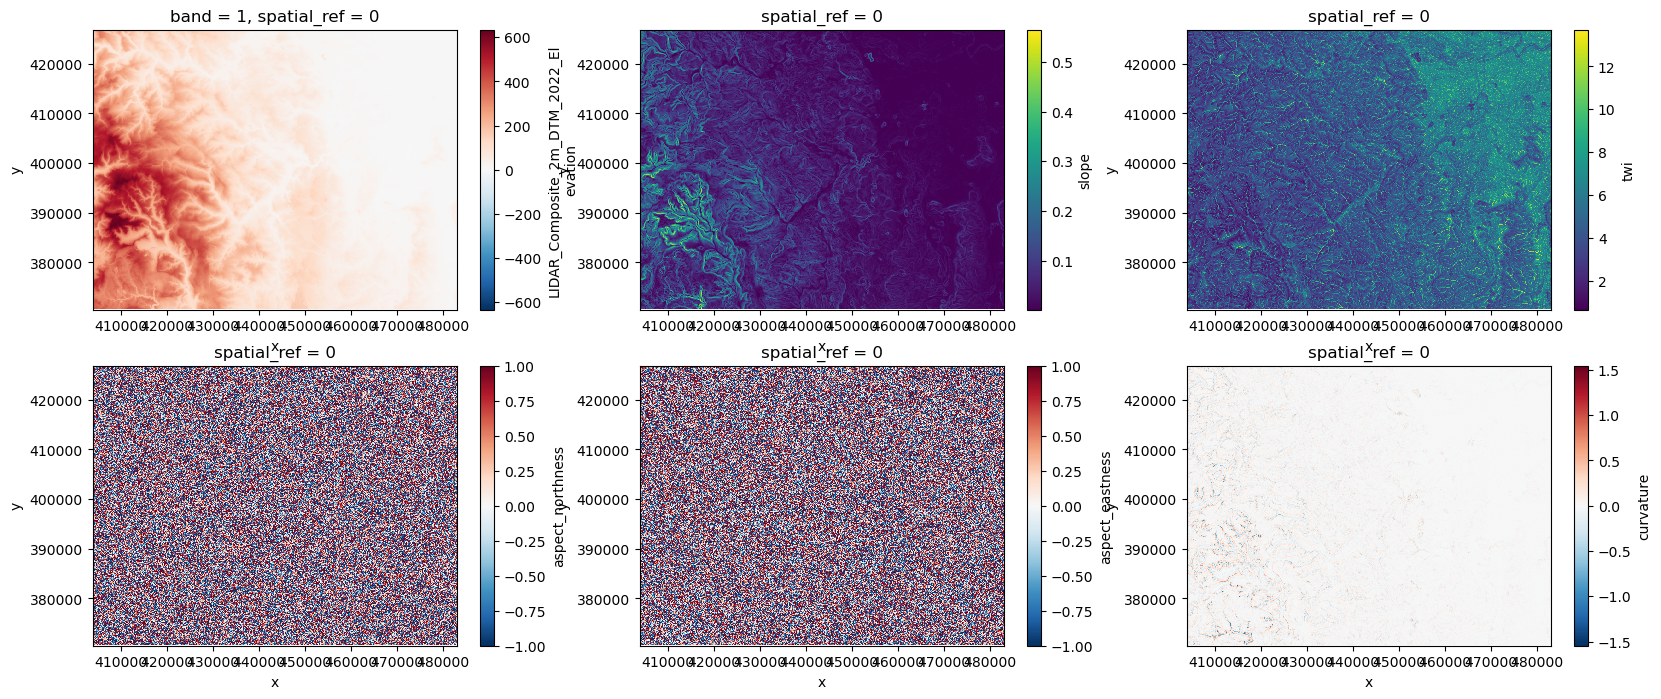

In [7]:
# Add the stats to the xarray
terrain["twi"] = (("y", "x"), twi)
terrain["slope"] = (("y", "x"), slope.data)
terrain["aspect_eastness"] = (("y", "x"), aspect_eastness)
terrain["aspect_northness"] = (("y", "x"), aspect_northness)
terrain["curvature"] = (("y", "x"), curvature.data)

# Plot them in subplots
fig, axes = plt.subplots(2, 3, figsize = (20, 8))
terrain.dem.plot(ax = axes[0, 0])
terrain.slope.plot(ax = axes[0, 1])
terrain.twi.plot(ax = axes[0, 2])
terrain.aspect_eastness.plot(ax = axes[1, 1])
terrain.aspect_northness.plot(ax = axes[1, 0])
terrain.curvature.plot(ax = axes[1, 2])
plt.show()

In [8]:
terrain["Roughness"] = terrain.slope.rolling(x=3, y=3, center=True).std()
terrain["tpi"] = terrain.dem - terrain.dem.rolling(x=3, y=3).mean()

/Users/matthewwhittle/opt/miniconda3/envs/bats/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


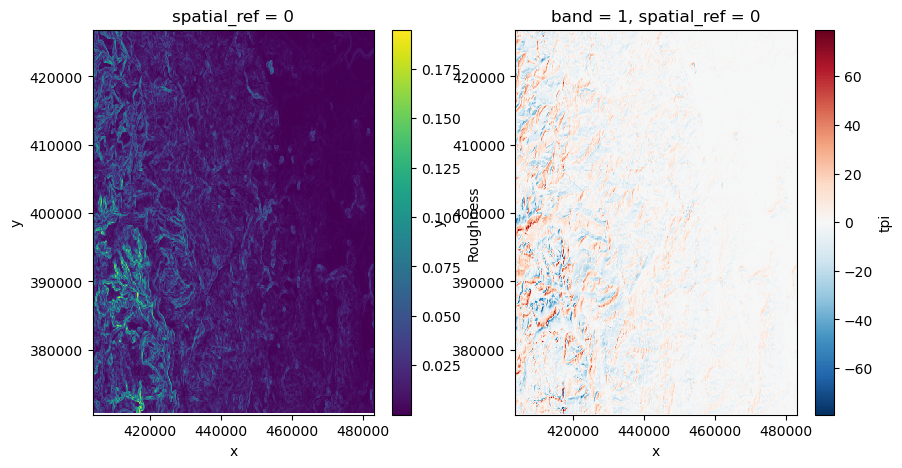

In [9]:
# Plot them in subplots
fig, axes = plt.subplots(1, 2, figsize = (10, 5))
terrain.Roughness.plot(ax = axes[0])
terrain.tpi.plot(ax = axes[1])
plt.show()

The aspect eastness and northeness values look a bit mesy. This is because they are calculated irrespective of the slope. However, the aspect of a face of a hill is not important if the slope is very shallow. To account for this, we can weight the aspect values by the slope to give a more meaningful aspect value.

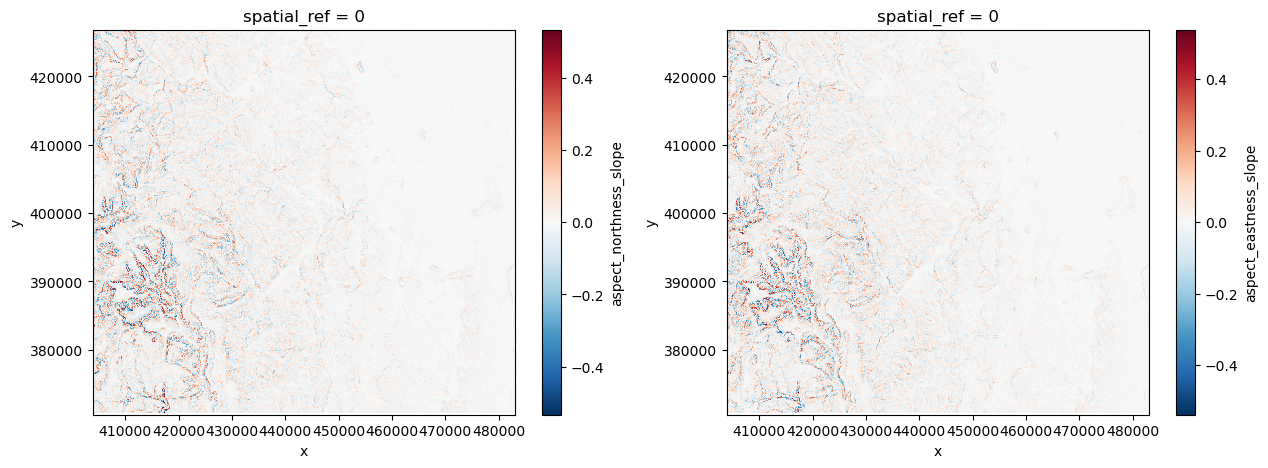

In [10]:
# Multiply the slope with the aspect
terrain["aspect_northness_slope"] = terrain.slope * terrain.aspect_northness
terrain["aspect_eastness_slope"] = terrain.slope * terrain.aspect_eastness

# Plot them in subplots
fig, axes = plt.subplots(1, 2, figsize = (15, 5))
terrain.aspect_northness_slope.plot(ax = axes[0])
terrain.aspect_eastness_slope.plot(ax = axes[1])
plt.show()

# Write the data

In [11]:
from sdm.geo import reproject_to_model_raster
# NEed to convert to array to make nodata available for projection.
# Squeeze converts to 3d
terrain = reproject_to_model_raster(terrain.to_array().squeeze())
terrain = terrain.to_dataset(dim = "variable")

In [12]:
# Drop the DEM as we already have it in another tif
terrain = terrain.drop_vars("dem")
terrain.rio.to_raster("data/evs/terrain-stats.tif")